In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import dataset
import myModels
import matplotlib.pyplot as plt
import scienceplots
import time
import Metrics
import LossFn

plt.style.use('science')
plt.rcParams['text.usetex'] = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\asus\.conda\envs\myTorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\asus\.conda\envs\myTorch_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
params = {
    'paths': os.path.abspath(os.path.join(os.getcwd(),'..')) + '/Datas/Thermal/',
    'inputs_FileName': ['Strains-50-1.xlsx','Strains-50-2.xlsx','Strains-100-1.xlsx','Strains-100-2.xlsx','Strains-120-1.xlsx'],
    'outputs_FileName': ['Loads-50-1.xlsx','Loads-50-2.xlsx','Loads-100-1.xlsx','Loads-100-2.xlsx','Loads-120-1.xlsx'],
    'SampleStride': [1,1,10,10,5],
    'seq_len': 100,
    'input_size': 14,
    'output_size': 6,
    'state':True,
    'Mask':True,
    'Robust_loss':False,
    'Noise_level': 0.0,
    'batch_size': 32,
    'CNN_layers': [40,80,120,80,30],
    'kernel_size':5,
    'dropout':0.1,
    'Epoches': 1500,
    'lr':0.001,
    'dis_interval':200,
    'plot_loss':True,
    'device':device,
}
Data_set = dataset.MyDataset(params)
test_size = int(len(Data_set)*0.1)
train_set, test_set = torch.utils.data.random_split(Data_set, [len(Data_set) - test_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_size, shuffle=True)

In [34]:
class CNN(nn.Module):
    def __init__(self, params):
        super(CNN, self).__init__()
        self.params = params
        
        # 获取卷积核尺寸和各层通道数
        kernel_size = self.params['kernel_size']
        cnn_layers = self.params['CNN_layers']
        
        # 模块列表，用于存储多个卷积层
        self.convs = nn.ModuleList()
        
        # 构建第一个卷积层，输入通道数为 input_size
        if self.params['state']: 
            self.convs.append(nn.Conv1d(in_channels=self.params['input_size']+1, 
                                        out_channels=cnn_layers[0], 
                                        kernel_size=kernel_size, 
                                        padding=kernel_size // 2))  # 保持长度不变
        else:
            self.convs.append(nn.Conv1d(in_channels=self.params['input_size'], 
                                        out_channels=cnn_layers[0], 
                                        kernel_size=kernel_size, 
                                        padding=kernel_size // 2))  # 保持长度不变            
        
        # 构建中间卷积层
        for i in range(1, len(cnn_layers)):
            self.convs.append(nn.Conv1d(in_channels=cnn_layers[i-1], 
                                        out_channels=cnn_layers[i], 
                                        kernel_size=kernel_size, 
                                        padding=kernel_size // 2))  # 保持长度不变
        
        # 最后一层卷积层，输出通道数为 output_size
        self.convs.append(nn.Conv1d(in_channels=cnn_layers[-1], 
                                    out_channels=self.params['output_size'], 
                                    kernel_size=kernel_size, 
                                    padding=kernel_size // 2))  # 保持长度不变
        
        # 激活函数
        self.activateF = nn.ReLU()
        
    def forward(self, x):
        # 输入形状为 (batch_size, length, input_size)
        # 需要转换为 (batch_size, input_size, length) 以适应 Conv1d
        x = x.permute(0, 2, 1)  # (batch_size, input_size, length)
        
        # 逐层通过卷积和激活函数
        for conv in self.convs[:-1]:  # 最后一层卷积不使用激活函数
            x = self.activateF(conv(x))
        
        # 最后一层卷积得到最终输出
        x = self.convs[-1](x)
        
        # 最终输出需要转换回 (batch_size, length, output_size) 形式
        x = x.permute(0, 2, 1)  # (batch_size, length, output_size)
        
        return x
    def _Train(self,optimizer,data_loader,loss_fn):
        torch.manual_seed(123)
        torch.cuda.manual_seed_all(123)
        since = time.time()
        train_losses = []
        self.train()
        for epoch in range(self.params['Epoches']):
            train_losses_batch = 0
            for _,data in enumerate(data_loader):
                optimizer.zero_grad()
                x = data[0].clone().detach().requires_grad_(True).float().to(self.params['device'])
                if self.params['Mask']:
                    x = dataset.mask_input(x,self.params)
                y = data[1].clone().detach().requires_grad_(True).float()
                out = self(x)
                loss = loss_fn(out,y)
                train_losses_batch += loss.item()

                loss.backward()
                optimizer.step()
            
            train_losses_mean = train_losses_batch / len(data_loader)
            train_losses.append(train_losses_mean)

            if (epoch % self.params['dis_interval'] == 0) or (epoch + 1 == self.params['Epoches']):
                print ('Train Epoch: {}, loss: {:.6f}'.format(epoch,train_losses_mean))
                if self.params['Robust_loss']:
                    mses, pearsons = loss_fn.getLossComponent()
                    print ('MSE = {}, pearsons = {}'.format(mses,pearsons))
                print ('--------------------------------------------------------')
        print ('***********************  Train is done  ***********************')
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        if self.params['plot_loss'] is True:
            plt.figure(figsize=(10,4))
            plt.plot(range(epoch+1),train_losses,'-*',color='black',linewidth=0.5,markersize=3)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
        return train_losses

In [33]:
models = CNN(params).to(params['device'])
total_params = sum(p.numel() for p in models.parameters())
total_params

128256

In [11]:
models = CNN(params).to(params['device'])
for _,data in enumerate(train_loader):
    x = data[0].clone().detach().requires_grad_(True).float().to(params['device'])
    y = data[1].clone().detach().requires_grad_(True).float()
    break
out = models(x)
print (out.size())

torch.Size([32, 100, 6])


Train Epoch: 0, loss: 1419.840366
--------------------------------------------------------
Train Epoch: 200, loss: 4.916030
--------------------------------------------------------
Train Epoch: 400, loss: 2.005509
--------------------------------------------------------
Train Epoch: 600, loss: 6.607431
--------------------------------------------------------
Train Epoch: 800, loss: 6.129852
--------------------------------------------------------
Train Epoch: 1000, loss: 2.295585
--------------------------------------------------------
Train Epoch: 1200, loss: 1.370896
--------------------------------------------------------
Train Epoch: 1400, loss: 6.289900
--------------------------------------------------------
Train Epoch: 1499, loss: 1.035619
--------------------------------------------------------
***********************  Train is done  ***********************
Training complete in 10m 44s


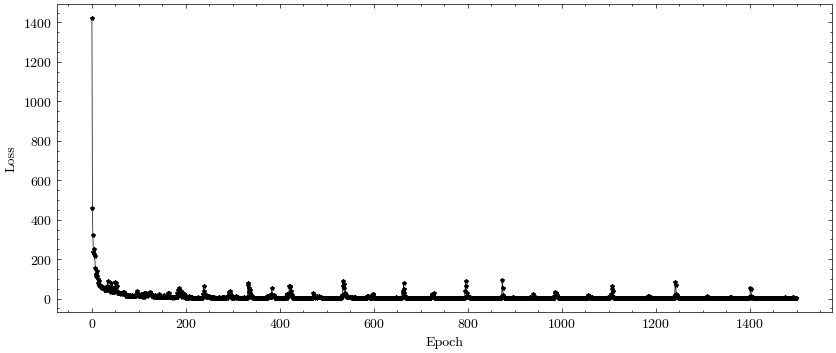

In [3]:
models = myModels.CNN(params).to(params['device'])
if params['Robust_loss']:
    loss_fn = LossFn.UncertaintyLoss(params)
    all_parameters = list(models.parameters()) + list(loss_fn.parameters())
else:
    loss_fn = nn.MSELoss()
    all_parameters = models.parameters()
    
optimizer = optim.Adam(all_parameters, params['lr'])
losses = models._Train(optimizer,train_loader,loss_fn)

In [5]:
torch.save(models,'CNN.pt')

0.9998193898213437


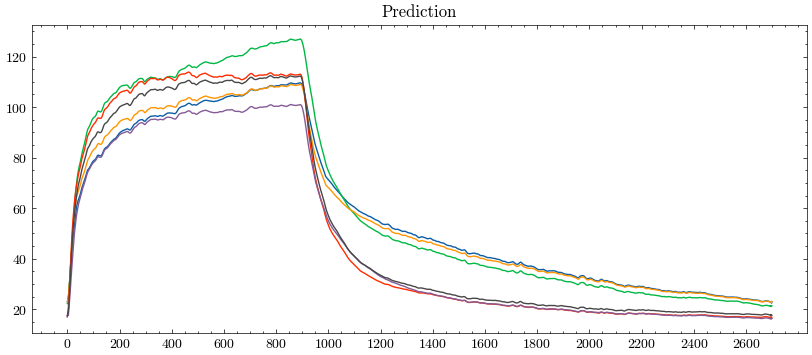

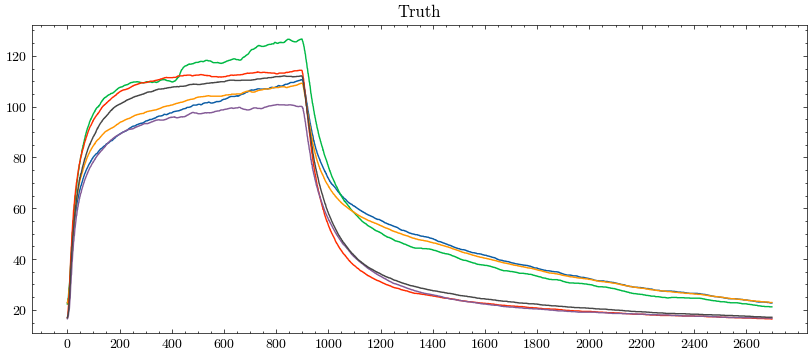

In [4]:
#models = torch.load('LSTM.pt')
labels = 4
start = 0
end = 2700
plot_step = 200
loads,preds = myModels.predict_varylength(models,params,labels,start,end,mask=False)
print (Metrics.Com_pearsonr(loads,preds))
plt.figure(figsize=(10,4))
plt.plot(preds.detach().numpy())
plt.title('Prediction')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads.cpu().detach().numpy())
plt.title('Truth')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()

In [24]:
from math import ceil,floor



def getDatas(params):
    Strains = []
    Loads = []
    if (len(params['Strains_FileName']) == len(params['Loads_FileName'])):
        FilesNum = len(params['Strains_FileName'])
        for num in range(FilesNum): #load data from each file
            strain = torch.tensor(dataset.getDataFromFile(params['Strains_FileName'][num],params['paths'],params['state']).values) #transfor to torch.tensor
            print (strain.size())
            load = torch.tensor(dataset.getDataFromFile(params['Loads_FileName'][num],params['paths'],state=True).values)
            data_length = strain.size(0) # compute length of each exprimental data
            
            if ((data_length-params['seq_len'])/params['SampleStride'][num]+1).is_integer(): # determine whether it can be rounded
                
                for i in range(floor(((data_length-params['seq_len'])/params['SampleStride'][num]+1))):
                    Strains.append(strain[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]])
                    Loads.append(load[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]]) 
                    
            else:                                                         # for 100-1 file
                for i in range(floor(((data_length-params['seq_len'])/params['SampleStride'][num]+1))):
                    Strains.append(strain[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]])
                    Loads.append(load[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]]) 
                Strains.append(strain[-params['seq_len']:])                         # Take 100 data points from the end of the data as a sample
                Loads.append(load[-params['seq_len']:])
    else: 
        print ('Files Warning!!! The number of strain files and the number of load files are not equal')
    
    Strains = torch.stack(Strains).double()
    Loads = torch.stack(Loads).double()
    
    return Strains,Loads
Strains,Loads = getDatas(params)
a = Strains[0]
a

torch.Size([128, 15])
torch.Size([124, 15])
torch.Size([1880, 15])
torch.Size([1780, 15])
torch.Size([2700, 15])


tensor([[ 0.0000, -2.2983, -1.9125,  ..., -2.0593,  0.2779, -1.4044],
        [ 0.0000, -2.3844, -1.8920,  ..., -2.1265,  0.2844, -1.3854],
        [ 0.0000, -2.4615, -1.9561,  ..., -2.2313,  0.2391, -1.4247],
        ...,
        [ 0.0000,  2.2908, 40.2872,  ..., 14.6726, -2.2112, 50.0418],
        [ 0.0000,  2.2253, 40.4052,  ..., 14.7049, -2.3084, 50.8201],
        [ 0.0000,  2.1970, 40.4924,  ..., 14.7527, -2.4029, 51.7255]],
       dtype=torch.float64)

In [37]:
def addGaussianNoise(Datas,Lambda,state):
    torch.manual_seed(123)
    Datas = Datas.clone()
    if state == False:
        noise = torch.randn_like(Datas)
        Datas += Lambda*torch.mul(noise,torch.mean(Datas))
    else:
        noise = torch.randn_like(Datas[:,1:])
        Datas[:,1:]  += Lambda*torch.mul(noise,torch.mean(Datas[:,1:]))
    return Datas
b = addGaussianNoise(a,0.01,True)
print (a)
print (b)

tensor([[ 0.0000e+00,  7.9607e-01, -6.7003e+00,  ..., -2.7199e+00,
          3.4826e+00, -3.3421e+00],
        [ 0.0000e+00, -4.8895e+00, -5.0963e+00,  ..., -5.3790e-01,
         -3.5342e+00,  3.2322e+00],
        [ 0.0000e+00, -1.0776e+01, -4.6599e-01,  ..., -1.6287e+00,
          5.6294e-01, -3.6490e+00],
        ...,
        [ 0.0000e+00,  5.3162e+00,  3.7716e+01,  ...,  1.7348e+01,
          5.7352e+00,  5.2292e+01],
        [ 0.0000e+00,  3.3437e-02,  3.7630e+01,  ...,  1.2390e+01,
          4.0152e+00,  4.4738e+01],
        [ 0.0000e+00,  6.1880e+00,  4.0540e+01,  ...,  1.3244e+01,
          6.2845e+00,  5.3706e+01]], dtype=torch.float64)
tensor([[ 0.0000e+00,  8.6885e-01, -6.6880e+00,  ..., -2.7003e+00,
          3.5679e+00, -3.2466e+00],
        [ 0.0000e+00, -4.7870e+00, -5.0460e+00,  ..., -5.0366e-01,
         -3.5729e+00,  3.2376e+00],
        [ 0.0000e+00, -1.0786e+01, -3.5248e-01,  ..., -1.7500e+00,
          4.9853e-01, -3.6780e+00],
        ...,
        [ 0.0000e+00,  5.

0.9945655967129675


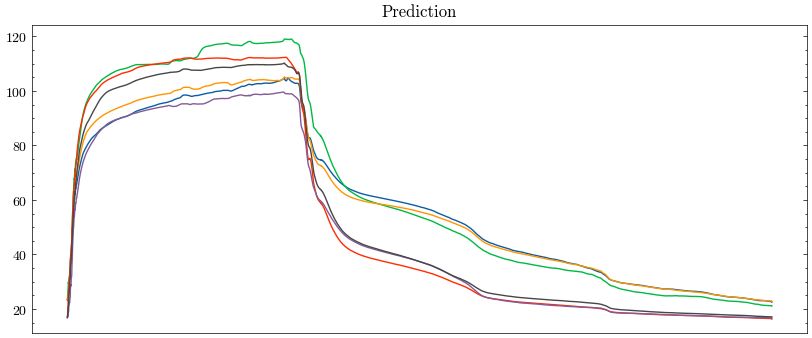

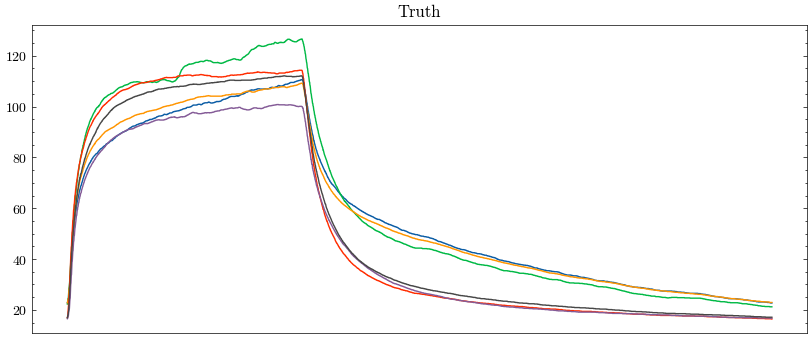

In [12]:
import numpy as np
models = torch.load('withState3w320002.pt')
labels = 4
start = 0
end = -1
plot_step = 50
loads,preds = myModels.predict_varylength(models,params,labels,start,end,mask=True)
print (Metrics.Com_pearsonr(loads,preds))
plt.figure(figsize=(10,4))
plt.plot(preds.detach().numpy())
plt.title('Prediction')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads.cpu().detach().numpy())
plt.title('Truth')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()

In [ ]:
def addGaussianNoise(Datas,Lambda,device):
    torch.manual_seed(123)
    Datas = Datas.to(device)
    shape = Datas[:,-1].size()
    noise = torch.randn(shape).to(device)
    torch.randn(shape,out=noise)
    Datas[:,-1] = Datas[:,-1] + Lambda*torch.mul(noise,torch.mean(Datas[:,-1]))
    return Datas


In [223]:
from scipy.stats import pearsonr
corr,_ = pearsonr(loads.flatten().detach().numpy(),preds.flatten().detach().numpy())
(1-corr)

0.09485358055572046

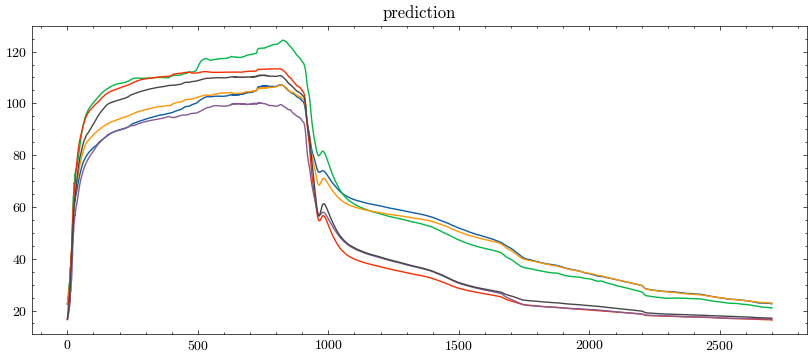

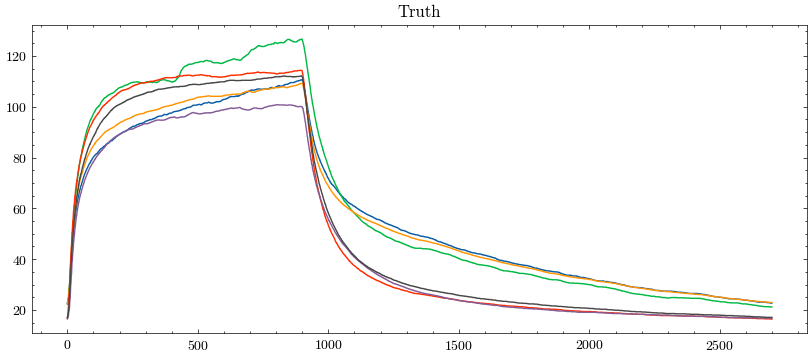

In [187]:
models = torch.load('withState3w320002.pt')
labels = 4
strains = dataset.getTensorFromFile(params['Strains_FileName'][labels],params['paths'],params['state'])
strains = dataset.mask_input(strains.to(params['device']),params)
start = 0
end = None
strains=strains[:,start:end,:]
loads = dataset.getTensorFromFile(params['Loads_FileName'][labels],params['paths'],params['state'])
pred = models(strains.to(params['device'])).cpu()
plt.figure(figsize=(10,4))
plt.plot(pred[0].detach().numpy())
plt.title('prediction')
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads[0][start:end,:].cpu().detach().numpy())
plt.title('Truth')
plt.show()

In [ ]:
import LossFn

models = myModels.deepLSTM(params).to(device)
loss_fn = LossFn.UncertaintyLoss(params)
if params['Robust_loss'] == True:
    all_parameters = list(models.parameters()) + list(loss_fn.parameters())
else:
    all_parameters = models.parameters()
optimizer = optim.Adam(all_parameters, params['lr'])
for _,data in enumerate(test_loader):
    optimizer.zero_grad()
    x = data[0].clone().detach().requires_grad_(True).float()
    x = dataset.mask_input(x,params).to(params['device'])
    y = data[1].clone().detach().requires_grad_(True).float()
    out = models(x)
    loss = loss_fn(out,y)
    print (loss)
    loss.backward()
    optimizer.step()
    break